# Flow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [2]:
from yamlparser import YAMLParser, read_parameterized_runs, read_unparameterized_runs

In [3]:
yp = YAMLParser()

In [5]:
# read parameterized runs
exps_param = yp.read('/glade/u/home/noraloose/GL90paper/config_param.yaml')
%time exps_param = read_parameterized_runs(exps_param, read_snapshots=True)

nw2_0.5deg_N15_KHTH800
nw2_0.5deg_N15_KHGL800_hbbl5
nw2_0.5deg_N15_KHTH800_vary
nw2_0.5deg_N15_KHGL800_vary_hbbl5
nw2_0.5deg_N15_EBT_KHTH800
nw2_0.5deg_N15_EBT_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300
nw2_0.25deg_N15_KHGL300_hbbl1
nw2_0.25deg_N15_KHGL300_hbbl5
nw2_0.25deg_N15_KHGL300_hbbl20
nw2_0.25deg_N15_KHGL300
nw2_0.25deg_N15_KHTH800
nw2_0.25deg_N15_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300_vary
nw2_0.25deg_N15_KHGL300_vary_hbbl5
nw2_0.25deg_N15_EBT_KHTH300
nw2_0.25deg_N15_EBT_KHGL300_hbbl5
nw2_0.125deg_N15_KHTH100
nw2_0.125deg_N15_KHGL100_hbbl5
nw2_0.125deg_N15_KHTH800
nw2_0.125deg_N15_KHGL800_hbbl5
nw2_0.125deg_N15_KHTH100_vary
nw2_0.125deg_N15_KHGL100_vary_hbbl5
nw2_0.125deg_N15_EBT_KHTH100
nw2_0.125deg_N15_EBT_KHGL100_hbbl5
CPU times: user 13.3 s, sys: 2.13 s, total: 15.4 s
Wall time: 3min 20s


In [6]:
# read unparameterized runs
exps_unparam = yp.read('/glade/u/home/noraloose/GL90paper/config_unparam.yaml')
%time exps_unparam = read_unparameterized_runs(exps_unparam, read_snapshots=True)

CPU times: user 1.18 s, sys: 575 ms, total: 1.76 s
Wall time: 16.1 s


In [7]:
for exps in [exps_param, exps_unparam]:
    for exp, v in exps.items():
        ds = v['ds']
        dst = ds.mean(dim='time', keep_attrs=True)
        if 'dst' in v: # some experiments have pre-computed time averaged fields
            for field in v['dst'].data_vars:
                dst[field] = v['dst'][field]
        v['dst'] = dst


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 12}
pylab.rcParams.update(params)

In [9]:
def plot_zonal_flow(exps, vmax, lon, lat_range, time=-1):  
    
    abc_list = ['(a)', '(b)', '', '(e)', '(f)', '(g)', '(h)', '(i)', '', '(j)', '(k)', '(l)', '(m)', '(n)']
    fig, axs = plt.subplots(5, 3, figsize=(12, 16.5))
    axs_flatten = axs.flatten()

    for exp, abc, ax in zip(exps, abc_list, axs.flatten()):
        if len(exp) > 0:
            dst = exp['sn'].isel(time=time)
            #print(exp['sn'].time.isel(time=time).values)
            #dst = exp['dst']  # for long-term means
            st = exp['st']
            label = exp['label']
            grid = exp['grid']

            e = dst.e.compute()
            eta_xy = grid.interp(e, ['X','Y'], boundary='fill').fillna(value=0).compute()

            fld_plot = dst['u'].sel(xq=lon, method="nearest").sel(yh=lat_range).compute()
            lon_exact = dst['u'].xq.sel(xq=lon, method="nearest")

            for i in range(16):
                ax.plot(dst.yq.sel(yq=lat_range), eta_xy.isel(zi=i).sel(xq=lon, method="nearest").sel(yq=lat_range), linewidth=1, color='k')
            p = ax.pcolormesh(
                            dst.yq.sel(yq=lat_range), eta_xy.sel(xq=lon, method="nearest").sel(yq=lat_range), fld_plot,
                            vmax=vmax, vmin=-vmax, cmap='RdBu_r'
            )

            ax.set(title='%s %s' %(abc, label), xlabel='', ylabel='')
            ax.set_yticks(np.arange(-4000, 1, 1000))
            ax.set_yticklabels(np.arange(4000, -1, -1000))
            ax.set_xticks([30, 40, 50])
            ax.set_xticklabels([r'30$^\circ$N', r'40$^\circ$N', r'50$^\circ$N'])

    for row in range(5):
        for ax in axs[row,1:]:
            ax.set_yticklabels([])

    for ax in [axs[0,0], axs[1,0], axs[2,0], axs[3,0], axs[4,0]]:
        ax.set(ylabel='Depth (m)')
        
    for ax in axs[4,:]:
        ax.set(xlabel=r'Latitude')

    
    axs[0,2].axis('off')
    axs[2,2].axis('off')
    axs[4,2].axis('off')
    
    # colorbar
    fig.subplots_adjust(left=0.1, bottom=-0.03)
    cax = fig.add_axes([0.1, -0.1, 0.8, 0.02])
    cb = fig.colorbar(p, cax=cax,extend='both', orientation='horizontal')
    cb.ax.tick_params(labelsize=14)
    cb.set_label(label=r'm s$^{-1}$', labelpad=15)
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    return fig


In [10]:
def plot_zonal_flow_zoom(exps, vmax, lon, lat_range, time=-1):  

    abc_list = ['(c)', '(d)']
    fig, axs = plt.subplots(2, 1, figsize=(3.64, 3))
    axs_flatten = axs.flatten()

    for exp, abc, ax in zip(exps, abc_list, axs.flatten()):
        if len(exp) > 0:
            dst = exp['sn'].isel(time=time)
            #print(exp['sn'].time.isel(time=time).values)
            #dst = exp['dst']  # for long term mean
            st = exp['st']
            label = exp['label']
            grid = exp['grid']

            e = dst.e.compute()
            eta_xy = grid.interp(e, ['X','Y'], boundary='fill').fillna(value=0).compute()

            fld_plot = dst['u'].sel(xq=lon, method="nearest").sel(yh=lat_range).compute()
            lon_exact = dst['u'].xq.sel(xq=lon, method="nearest")

            for i in range(16):
                ax.plot(dst.yq.sel(yq=lat_range), eta_xy.isel(zi=i).sel(xq=lon, method="nearest").sel(yq=lat_range), linewidth=1, color='k')
            p = ax.pcolormesh(
                            dst.yq.sel(yq=lat_range), eta_xy.sel(xq=lon, method="nearest").sel(yq=lat_range), fld_plot,
                            vmax=vmax, vmin=-vmax, cmap='RdBu_r'
            )

            ax.set_ylim([-500, 0])
            ax.set(title='%s %s' %(abc, label), xlabel='', ylabel='')
            ax.set_yticks(np.arange(-500, 1, 250))
            ax.set_yticklabels(np.arange(500, -1, -250))
            ax.set_xticks([30, 40, 50])
            ax.set_xticklabels([r'30$^\circ$N', r'40$^\circ$N', r'50$^\circ$N'])
            
    plt.subplots_adjust(hspace=0.9)  
    return fig


### Clean up labels

In [11]:
v = exps_param['nw2_0.5deg_N15_KHGL800_hbbl5']
v['label'] = r'1/2$^\circ$ GL 800'
v = exps_param['nw2_0.25deg_N15_KHGL300_hbbl5']
v['label'] = r'1/4$^\circ$ GL 300'
v = exps_param['nw2_0.25deg_N15_KHGL800_hbbl5']
v['label'] = r'1/4$^\circ$ GL 800'
v = exps_param['nw2_0.125deg_N15_KHGL100_hbbl5']
v['label'] = r'1/8$^\circ$ GL 100'
v = exps_param['nw2_0.125deg_N15_KHGL800_hbbl5']
v['label'] = r'1/8$^\circ$ GL 800'

## Zonal snapshot velocities in Gulf Stream @7E

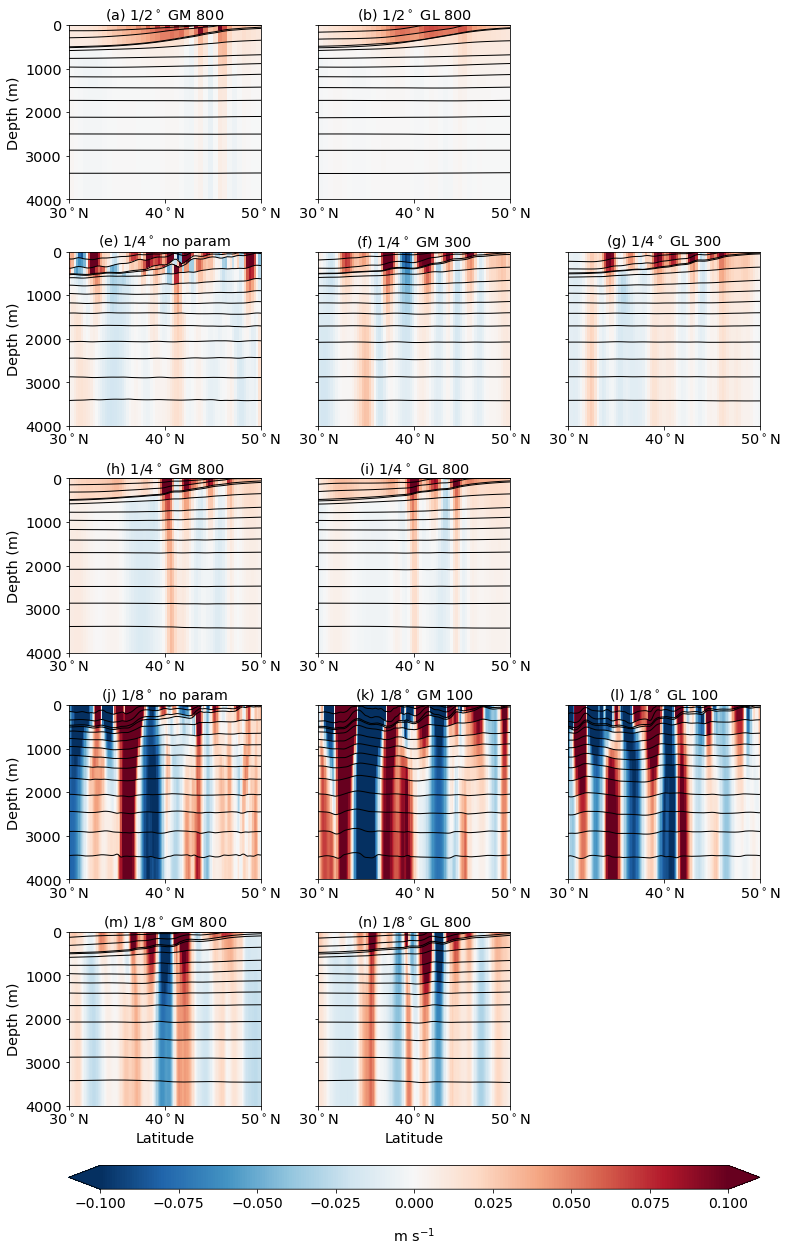

In [12]:
vmax = 0.1
lat_range = slice(30, 50)
lon = 7

exps = [
    exps_param['nw2_0.5deg_N15_KHTH800'],
    exps_param['nw2_0.5deg_N15_KHGL800_hbbl5'],
    '',  
    exps_unparam['nw2_0.25deg_N15_baseline_hmix20'],
    exps_param['nw2_0.25deg_N15_KHTH300'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl5'],
    exps_param['nw2_0.25deg_N15_KHTH800'],
    exps_param['nw2_0.25deg_N15_KHGL800_hbbl5'],
    '',
    exps_unparam['nw2_0.125deg_N15_baseline_hmix20'],
    exps_param['nw2_0.125deg_N15_KHTH100'],
    exps_param['nw2_0.125deg_N15_KHGL100_hbbl5'],
    exps_param['nw2_0.125deg_N15_KHTH800'],
    exps_param['nw2_0.125deg_N15_KHGL800_hbbl5']
]

fig = plot_zonal_flow(exps, vmax, lon, lat_range, time=-1)
figname = '/glade/u/home/noraloose/GL90paper/figures/zonal_Gulf_lon%i.png' %lon
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

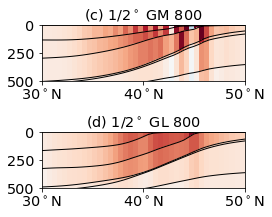

In [13]:
vmax = 0.1
lat_range = slice(30, 50)
lon = 7

exps = [
    exps_param['nw2_0.5deg_N15_KHTH800'],
    exps_param['nw2_0.5deg_N15_KHGL800_hbbl5']
]

fig = plot_zonal_flow_zoom(exps, vmax, lon, lat_range, time=-1)
figname = '/glade/u/home/noraloose/GL90paper/figures/zonal_Gulf_lon%i_zoom.png' %lon
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

## Probe higher resolution experiments at different longitudes (still at Gulf Stream latitudes)

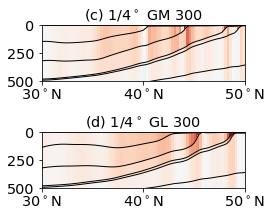

In [14]:
vmax = 0.2
lat_range = slice(30, 50)
lon = 15

exps = [
    exps_param['nw2_0.25deg_N15_KHTH300'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl5']
]

fig = plot_zonal_flow_zoom(exps, vmax, lon, lat_range, time=-1)

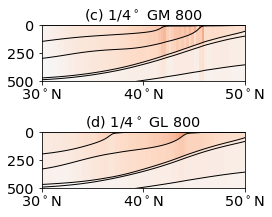

In [15]:
vmax = 0.2
lat_range = slice(30, 50)
lon = 15

exps = [
    exps_param['nw2_0.25deg_N15_KHTH800'],
    exps_param['nw2_0.25deg_N15_KHGL800_hbbl5']
]

fig = plot_zonal_flow_zoom(exps, vmax, lon, lat_range, time=-1)

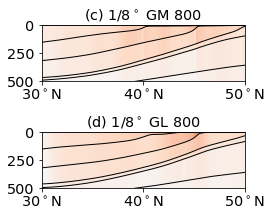

In [16]:
vmax = 0.2
lat_range = slice(30, 50)
lon = 13

exps = [
    exps_param['nw2_0.125deg_N15_KHTH800'],
    exps_param['nw2_0.125deg_N15_KHGL800_hbbl5']
]

fig = plot_zonal_flow_zoom(exps, vmax, lon, lat_range, time=-1)

# Additional experiments

### Clean up labels

In [18]:
v = exps_param['nw2_0.5deg_N15_KHGL800_vary_hbbl5']
v['label'] = r'1/2$^\circ$ GL 800 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.5deg_N15_KHTH800_vary']
v['label'] = r'1/2$^\circ$ GM 800 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.5deg_N15_EBT_KHGL800_hbbl5']
v['label'] = r'1/2$^\circ$ GL 800 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.5deg_N15_EBT_KHTH800']
v['label'] = r'1/2$^\circ$ GM 800 $\cdot\, \phi(z)$'

v = exps_param['nw2_0.25deg_N15_EBT_KHGL300_hbbl5']
v['label'] = r'1/4$^\circ$ GL 300 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.25deg_N15_EBT_KHTH300']
v['label'] = r'1/4$^\circ$ GM 300 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.25deg_N15_KHGL300_vary_hbbl5']
v['label'] = r'1/4$^\circ$ GL 300 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.25deg_N15_KHTH300_vary']
v['label'] = r'1/4$^\circ$ GM 300 $\cdot\, \psi(y)$'

v = exps_param['nw2_0.125deg_N15_EBT_KHGL100_hbbl5']
v['label'] = r'1/8$^\circ$ GL 100 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.125deg_N15_KHGL100_vary_hbbl5']
v['label'] = r'1/8$^\circ$ GL 100 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.125deg_N15_EBT_KHTH100']
v['label'] = r'1/8$^\circ$ GM 100 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.125deg_N15_KHTH100_vary']
v['label'] = r'1/8$^\circ$ GM 100 $\cdot\, \psi(y)$'


## Zonal snapshot velocities in Gulf Stream @7E

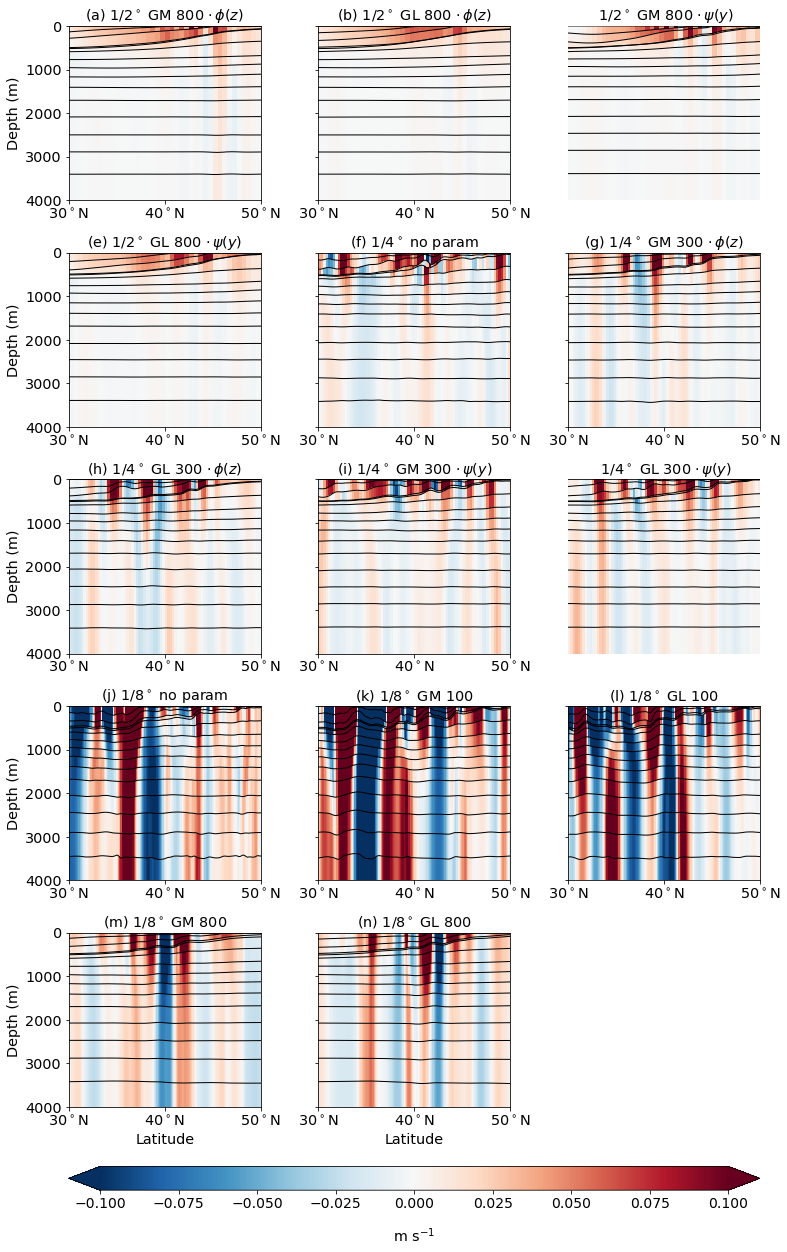

In [19]:
vmax = 0.1
lat_range = slice(30, 50)
lon = 7

exps = [
    exps_param['nw2_0.5deg_N15_EBT_KHTH800'],
    exps_param['nw2_0.5deg_N15_EBT_KHGL800_hbbl5'],
    exps_param['nw2_0.5deg_N15_KHTH800_vary'],
    exps_param['nw2_0.5deg_N15_KHGL800_vary_hbbl5'],
    exps_unparam['nw2_0.25deg_N15_baseline_hmix20'],
    exps_param['nw2_0.25deg_N15_EBT_KHTH300'],
    exps_param['nw2_0.25deg_N15_EBT_KHGL300_hbbl5'],
    exps_param['nw2_0.25deg_N15_KHTH300_vary'],
    exps_param['nw2_0.25deg_N15_KHGL300_vary_hbbl5'],
    exps_unparam['nw2_0.125deg_N15_baseline_hmix20'],
    exps_param['nw2_0.125deg_N15_KHTH100'],
    exps_param['nw2_0.125deg_N15_KHGL100_hbbl5'],
    exps_param['nw2_0.125deg_N15_KHTH800'],
    exps_param['nw2_0.125deg_N15_KHGL800_hbbl5']
]

fig = plot_zonal_flow(exps, vmax, lon, lat_range, time=-1)

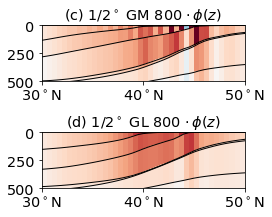

In [20]:
vmax = 0.1
lat_range = slice(30, 50)
lon = 7

exps = [
    exps_param['nw2_0.5deg_N15_EBT_KHTH800'],
    exps_param['nw2_0.5deg_N15_EBT_KHGL800_hbbl5']
]

fig = plot_zonal_flow_zoom(exps, vmax, lon, lat_range, time=-1)

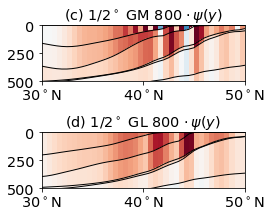

In [21]:
vmax = 0.1
lat_range = slice(30, 50)
lon = 7

exps = [
    exps_param['nw2_0.5deg_N15_KHTH800_vary'],
    exps_param['nw2_0.5deg_N15_KHGL800_vary_hbbl5']
]

fig = plot_zonal_flow_zoom(exps, vmax, lon, lat_range, time=-1)

### What about the ACC?

In [24]:
def plot_zonal_flow_ACC_zoom(exps, vmax, lon, lat_range, time=-1):  

    abc_list = ['(c)', '(d)']
    fig, axs = plt.subplots(2, 1, figsize=(3.64, 3))
    axs_flatten = axs.flatten()

    for exp, abc, ax in zip(exps, abc_list, axs.flatten()):
        if len(exp) > 0:
            dst = exp['sn'].isel(time=time)
            #print(exp['sn'].time.isel(time=time).values)
            st = exp['st']
            label = exp['label']
            grid = exp['grid']

            e = dst.e.compute()
            eta_xy = grid.interp(e, ['X','Y'], boundary='fill').fillna(value=0).compute()

            fld_plot = dst['u'].sel(xq=lon, method="nearest").sel(yh=lat_range).compute()
            lon_exact = dst['u'].xq.sel(xq=lon, method="nearest")

            for i in range(16):
                ax.plot(dst.yq.sel(yq=lat_range), eta_xy.isel(zi=i).sel(xq=lon, method="nearest").sel(yq=lat_range), linewidth=1, color='k')
            p = ax.pcolormesh(
                            dst.yq.sel(yq=lat_range), eta_xy.sel(xq=lon, method="nearest").sel(yq=lat_range), fld_plot,
                            vmax=vmax, vmin=-vmax, cmap='RdBu_r'
            )

            ax.set_ylim([-500, 0])
            ax.set(title='%s %s' %(abc, label), xlabel='', ylabel='')
            ax.set_yticks(np.arange(-500, 1, 250))
            ax.set_yticklabels(np.arange(500, -1, -250))
            ax.set_xticks([-60, -50, -40])
            ax.set_xticklabels([r'60$^\circ$S', r'50$^\circ$S', r'40$^\circ$S'])
            
    plt.subplots_adjust(hspace=0.9)  
    return fig


Some GM90 experiments show noisy surface velocities even in the ACC!

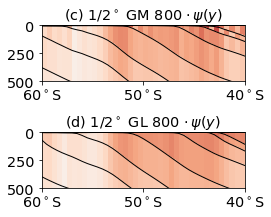

In [25]:
vmax = 0.3
lat_range = slice(-60, -40)
lon = 10

exps = [
    exps_param['nw2_0.5deg_N15_KHTH800_vary'],
    exps_param['nw2_0.5deg_N15_KHGL800_vary_hbbl5']
]

fig = plot_zonal_flow_ACC_zoom(exps, vmax, lon, lat_range, time=-1)